In [8]:
# Imports and configuration
%load_ext autoreload
%autoreload 2

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
import src.helpers.model_helpers as mh
from scipy.stats import randint, loguniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
from sklearn.metrics import f1_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Load modeling dataset and the split indices
X_train, y_train, X_test, y_test = mh.load_model_dataset(fraction=0.005)

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model.parquet


In [10]:
# Create and train model
base_hgbm = HistGradientBoostingClassifier(random_state=42, early_stopping=True, validation_fraction=0.1, n_iter_no_change=30)
param_grid = {
    "learning_rate": loguniform(1e-3, 1e-1),
    "max_iter": randint(400, 1500),
    "max_depth": [2, 3, 4],
    "max_leaf_nodes": randint(16, 96),
    "min_samples_leaf": randint(100, 600),
    "l2_regularization": loguniform(1e-4, 10),
    "max_bins": randint(64, 255),
}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

search = RandomizedSearchCV(
    estimator=base_hgbm,
    param_distributions=param_grid,
    n_iter=3,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True
)

search.fit(X_train, y_train, sample_weight=weight_train)

/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setup

,estimator,HistGradientB...ndom_state=42)
,param_distributions,"{'l2_regularization': <scipy.stats....t 0x12d032b10>, 'learning_rate': <scipy.stats....t 0x12cfe3230>, 'max_bins': <scipy.stats....t 0x1ae5dc410>, 'max_depth': [2, 3, ...], ...}"
,n_iter,3
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [11]:
# Calculate F1 for validation
mh.output_cv_summary(search)

Best params: {'l2_regularization': np.float64(0.00010090061869151566), 'learning_rate': np.float64(0.09647685075720101), 'max_bins': 224, 'max_depth': 3, 'max_iter': 421, 'max_leaf_nodes': 64, 'min_samples_leaf': 574}
Best CV F1: 0.7712886682875206


In [16]:
# Calculate metrics
results, y_pred, y_prob = mh.calculate_test_metrics(search, X_test, y_test)

# Save metrics to CSV
mh.save_metrics_to_csv(results, "hgbm_metrics_csv")

# Display metrics
print("Test Performance:")
display(results)

Best threshold = 0.5527638190954774, F1 = 0.6511627906976745
Test Performance:


,Score
F1,0.651163
Accuracy,0.814508
Precision,0.592058
Recall,0.723377
ROC AUC,0.864883
PR AUC,0.714717


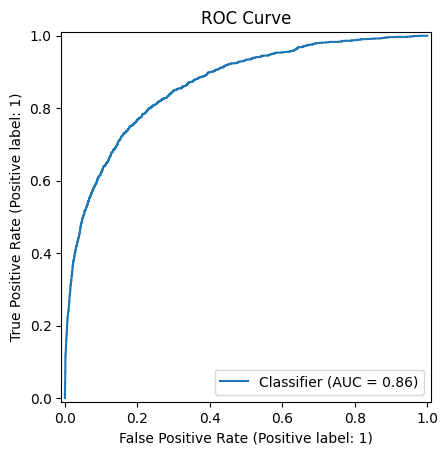

In [17]:
# ROC Curve
mh.draw_roc_curve(y_test, y_prob, "hgbm_roc")

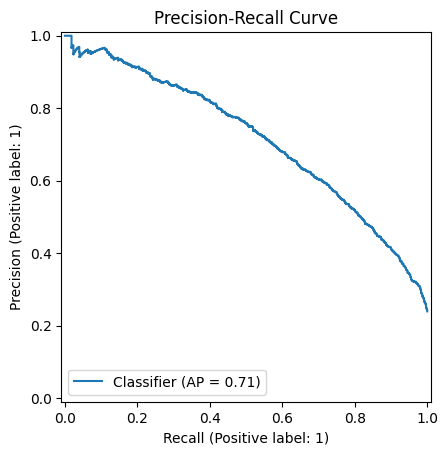

In [18]:
# PR Curve
mh.draw_pr_curve(y_test, y_prob, "hgbm_pr")

In [19]:
# Persist fitted model
mh.persist_model(search, "hgbm_model")

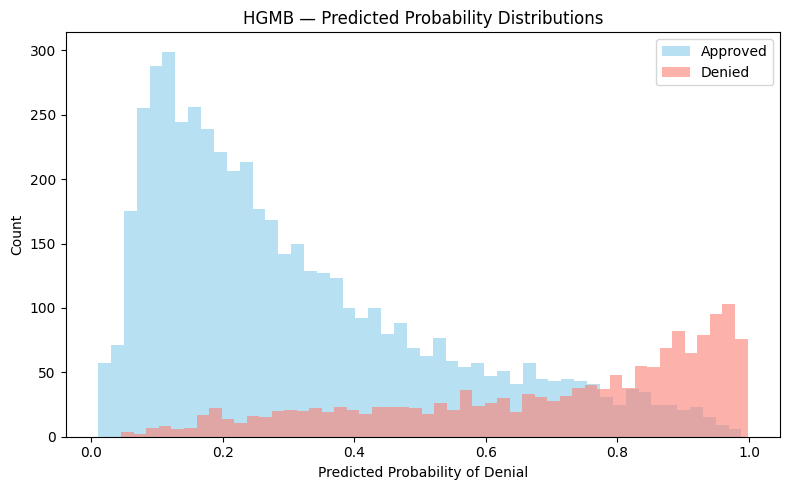

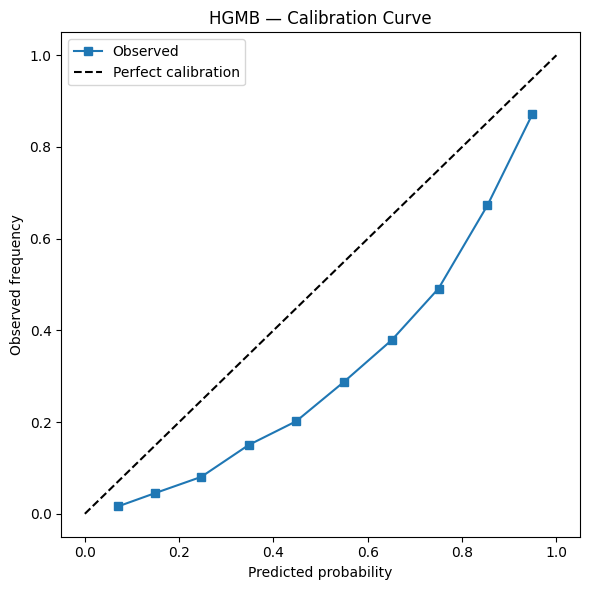

In [20]:
# Plot diagnostic charts to see how to further optimize model
mh.plot_probability_distributions(y_test, y_prob, "HGMB")
mh.plot_calibration_curve(y_test, y_prob, "HGMB")